In [1]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import bitarray, time, urllib, ssl
from scipy import signal, integrate
from fractions import gcd

%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
def lcm(numbers):
    return reduce(lambda x, y: (x*y)/gcd(x,y), numbers, 1)

# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = floor(len(x)/N)
    x_ = reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return r_[-N/2.0:N/2.0]/N*fs, mean(abs(X)**2,axis=0)


In [78]:
def afsk(bits, fs = 48000, baud = 1200, mark_f = 1200, space_f = 2200):
    fss = lcm((baud, fs))
    deci = fss/fs
    
    Nb = fss/baud
    nb = len(bits)
    NRZ = ones((nb,Nb))
    for n in range(0,nb):
        if bits[n]:
            NRZ[n,:] = -NRZ[n,:]
    
    freq = 1700 + 500*NRZ.ravel()
    ph = 2.0*pi*integrate.cumtrapz(freq, initial=0)/fss
    sig = cos(ph[::deci])
    
    return sig

def afsk1200(bits, fs = 48000):
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at 44100Hz
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal
    
    # your code below:
    mark_f = 1200
    space_f = 2200
    
    fs_lcm = lcm((1200, fs))
    
    fc = (mark_f+space_f)/2
    br = 1200
    df = (mark_f-space_f)/2
    
    samples_per_bit = fs_lcm/br
    mark_f = np.empty(0)
    
    N = samples_per_bit*len(bits)
    
    for i in bits:
        mark_f = np.r_[mark_f, np.repeat(1 if i else -1, samples_per_bit)]
        
    t = np.linspace(0,len(bits)*1.0/br,N-1)
    
    phase = 2*pi*fc*t + 2*pi*df*integrate.cumtrapz(mark_f*(1.0/fs_lcm))
    sig = np.cos(phase)
    
    return sig[::fs_lcm/fs]

def nc_afsk1200Demod(sig, fs=48000, baud=1200, TBW=2.0, mark_f=1200, space_f=2200):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 1200
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    
    # Generate filters
    N = (fs*TBW*1.0/baud // 2) * 2 + 1
        
    h_lp = signal.firwin(N, 600, nyq=fs/2, window='hanning')
    h_lpp = signal.firwin(N, 1200, nyq=fs/2, window='hanning')
    h_s = np.exp(1j*2*pi*np.arange(N)*space_f/fs) * h_lp
    h_m = np.exp(1j*2*pi*np.arange(N)*mark_f/fs) * h_lp
    h_bp = signal.firwin(N,800, nyq=fs/2, window='hanning')*exp(1j*2*pi*1700*np.arange(N)/fs)
    
    #sig = signal.fftconvolve(sig, h_bp, mode='valid')
    space = signal.fftconvolve(sig, h_s, mode='same')
    mark = signal.fftconvolve(sig, h_m, mode='same')
    NRZa = np.abs(space) - np.abs(mark) 
    #NRZa = signal.fftconvolve(NRZa, h_lpp, mode='valid')
    
    return NRZa

def nc_afsk1200Demod(sig, fs=48000.0, baud=1200, TBW=2.0):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 1200
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    
    # your code here
    N = (fs*TBW*1.0/1200 // 2) * 2 + 1
    h = signal.firwin(N,600.0,nyq=fs/2,window='hanning')

    t = np.arange(0,N*1.0/fs, 1.0/fs)
    
    h_s = np.exp(1j*2*pi*t*1200) * h
    h_m = np.exp(1j*2*pi*t*2200) * h

    space = np.abs(signal.fftconvolve(sig, h_s, mode='same'))
    mark = np.abs(signal.fftconvolve(sig, h_m, mode='same'))

    NRZ = space - mark
    return NRZ

def PLL(NRZa, a = 0.74 , fs = 48000, baud = 1200):
    # 
    # function implements a simple phased lock loop for timing recovery
    #
    # Inputs:
    #          NRZa -   The NRZ signal
    #          a - nudge factor
    #          fs - sampling rate (arbitrary)
    #          baude  - the bit rate
    #
    # Outputs:
    #          idx - array of indexes to sample at
    #
    #ctr = int32(-2147483648)
    Ns = 1.0*fs/baud
    idx = zeros(len(NRZa)//int(Ns)*2)
    dpll = np.round(2.0**32 / Ns).astype(int32)
    
    c = 0
    pll = 0
    ppll = 0
    
    for n in range(1, len(NRZa)):
        if pll < 0 and ppll > 0:
            idx[c] = n
            c = c+1
        if np.sign(NRZa[n]) != np.sign(NRZa[n-1]):
            pll = int32(pll*a)
        
        ppll = int32(pll)
        pll = int32(pll+dpll)
    
    return idx[:c].astype(int32)
    

/Users/shane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


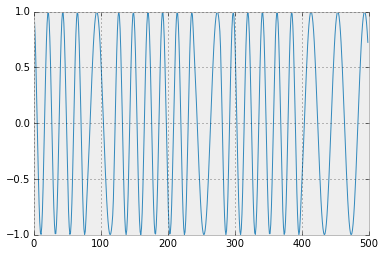

In [80]:
fs = 48e3
baud = 1200
mark_f, space_f = 1200, 2200 #mark and space multiplse
df = 10
L = 4000
sigma = 0

bits = bitarray.bitarray((rand(L)>0.5).tolist())
# sig = afsk(bits, fs=fs, baud=baud, mark_f=mark_f, space_f=space_f)
sig = afsk1200(bits, fs)

plt.plot(sig[:500])
plt.show()

81.0


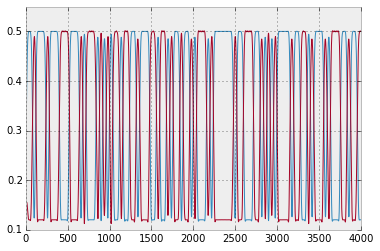

In [81]:
N = (fs*2.0*1.0/baud // 2) * 2 + 1
print N
h_lp = signal.firwin(N, 600, nyq=fs/2, window='hanning')

h_s = np.exp(1j*2*pi*np.arange(N)*space_f/fs) * h_lp
h_m = np.exp(1j*2*pi*np.arange(N)*mark_f/fs) * h_lp

space = signal.fftconvolve(sig, h_s, mode='same')
mark = signal.fftconvolve(sig, h_m, mode='same')

plt.plot(np.abs(space[:4000]))
plt.plot(np.abs(mark[:4000]))
plt.show()

NRZa = np.abs(mark)-np.abs(space)

/Users/shane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


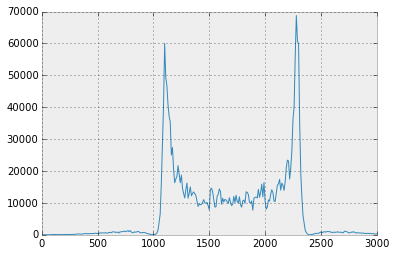

In [82]:
sig = sig + sigma*np.random.randn(sig.shape[0])

f, P = avgPS(sig, N=int(fs/df), fs=fs)
plt.plot(f,P)
plt.axis([0,3e3,0,70000])
plt.show()

0.50475
bitarray('0010001000')
bitarray('1010110010')


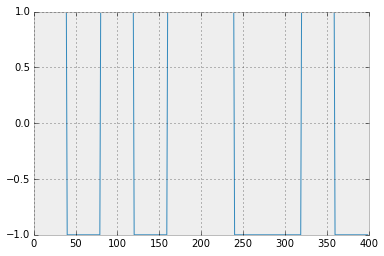

In [83]:
NRZa = nc_afsk1200Demod(sig, fs)
NRZ = np.sign(NRZ)

samples_per_bit = int(fs/baud)
idx = np.r_[samples_per_bit/2:NRZ.shape[0]:samples_per_bit]

bit_dec = bitarray.bitarray((NRZ[idx] > 0).tolist())

num_correct = (~(bits ^ bit_dec)).count()
BER = (L-num_correct*1.0)/L
print BER

print bits[:10]
print bit_dec[:10]

plt.plot(NRZ[:400])

In [146]:
sigmas = [0, 1, 1.5, 2]
bauds = [1200, 1600, 2400]
#minimum-shift keying
fc = 1800
dfs = [600]
bits = bitarray.bitarray((rand(L)>0.5).tolist())

for s in sigmas:
    for baud in bauds:
        for df in dfs:
            mark_f, space_f = fc-df, fc+df #mark and space multiplse
            sigma = 1

            sig = afsk(bits, fs=fs, baud=baud, mark_f=mark_f, space_f=space_f)

            sig = sig + s*np.random.randn(sig.shape[0])
            NRZa = nc_afsk1200Demod(sig, fs, baud, mark_f=mark_f, space_f=space_f)
            Ns = int(1.0*fs/baud)
            idx = np.r_[Ns/2:NRZa.shape[0]:Ns]
            
            bit_dec = bitarray.bitarray((NRZa[idx] > 0).tolist())

            num_correct = (~(bits ^ bit_dec)).count()
            BER = (L-num_correct*1.0)/L
            print s, baud, df, BER

0 1200 600 0.0
0 1600 600 0.0
0 2400 600 0.0
1 1200 600 0.00333333333333
1 1600 600 0.00666666666667
1 2400 600 0.0633333333333
1.5 1200 600 0.0666666666667
1.5 1600 600 0.0533333333333
1.5 2400 600 0.126666666667
2 1200 600 0.136666666667
2 1600 600 0.13
2 2400 600 0.246666666667


/Users/shane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [92]:
NRZa = nc_afsk1200Demod(sig, fs, baud)
idx = PLL(NRZa, baud=baud)

bit_dec = bitarray.bitarray((NRZa[idx] > 0).tolist())

num_correct = (~(bits ^ bit_dec)).count()
BER = (L-num_correct*1.0)/L

print BER

ValueError: bitarrays of equal length expected for bitwise operation